In [ ]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.1 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2023.1-cp310-cp310-linux_x86_64.whl size=661263 sha256=2a86e577fef7074fc5b2cca3f4b590b3bd374b5d37d6a6640fd9568c6f2b5f4e
  Stored in directory: /root/.cache/pip/wheels/46/65/06/b997165edd2fd9690c3497ca54ea4485b571d7bd959c21c6c4
Successfully built pycuda


In [ ]:
from pycuda import driver, compiler, gpuarray
import pycuda.autoinit
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow
from pycuda.compiler import SourceModule
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def bilateral_CPU(image, sigma_d, sigma_r, window_size):
    cpu_img = np.zeros(image.shape)
    width, height = image.shape
    half_window = window_size // 2
    for i in range(half_window, width - half_window):
        for j in range(half_window, height - half_window):
          s = c = 0
          for k in range(i - half_window, i + half_window + 1):
              for l in range(j - half_window, j + half_window + 1):
                  if k >= 0 and k < width and l >= 0 and l < height:
                      g = np.exp(-((k - i) ** 2 + (l - j) ** 2) / sigma_d ** 2)
                      r = np.exp(-((image[k, l] - image[i, j]) ** 2) / sigma_r ** 2)
                      c += g * r
                      s += g * r * image[k, l]
          cpu_img[i, j] = s / c
    return cpu_img

In [ ]:
def bilateral_filter(image, sigma_d, sigma_r, window_size):
    M, N = image.shape
    gpu_img = np.zeros((M, N), dtype=np.uint32)
    block = (32, 1, 1)
    grid = (int(np.ceil(M/block[0])), int(np.ceil(N/block[1])))

    bilateral_GPU = SourceModule("""
    texture<unsigned int, 2, cudaReadModeElementType> t;

    __global__ void kernel_gpu(int *  res, const int M, const int N, const int window_size, const float sigma_d, const float sigma_r)
    {
        int i = threadIdx.x + blockDim.x * blockIdx.x;
        int j = threadIdx.y + blockDim.y * blockIdx.y;

        if (i >= M || j >= N)
          return;

        float firstImg, secondImg, g, r, s = 0, c = 0;

        int half_window = window_size / 2;

        for (int l = i - half_window; l <= i + half_window; l++){
            for (int k = j - half_window; k <= j + half_window; k++){
                if (l >= 0 && l < M && k >= 0 && k < N) {
                    firstImg = tex2D(t, k, l) / 255;
                    secondImg = tex2D(t, i, j) / 255;
                    g = exp(-(pow(k - i, 2) + pow(l - j, 2)) / pow(sigma_d, 2));
                    r = exp(-pow((firstImg - secondImg) * 255, 2) / pow(sigma_r, 2));
                    c += g * r;
                    s += g * r * tex2D(t, k, l);
                }
            }
        }

        res[i * N + j] = s / c;
    }
    """)

    kernel_gpu = bilateral_GPU.get_function("kernel_gpu")
    t = bilateral_GPU.get_texref("t")
    t.set_filter_mode(driver.filter_mode.LINEAR)
    t.set_address_mode(0, driver.address_mode.MIRROR)
    t.set_address_mode(1, driver.address_mode.MIRROR)
    driver.matrix_to_texref(image.astype(np.uint32), t, order="C")
    kernel_gpu(driver.Out(gpu_img), np.int32(M), np.int32(N), np.int32(window_size), np.float32(sigma_d), np.float32(sigma_r), block=block, grid=grid, texrefs=[t])

    return gpu_img

Billy original


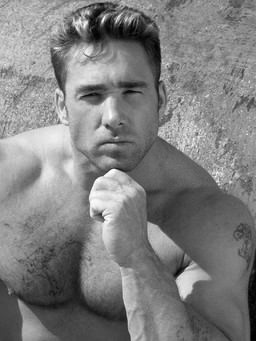

<ipython-input-4-689d7e21db7e>:12: RuntimeWarning: overflow encountered in ubyte_scalars
  r = np.exp(-((image[k, l] - image[i, j]) ** 2) / sigma_r ** 2)


Billy CPU


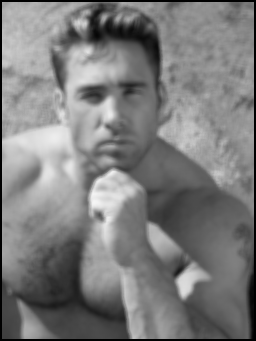

Time CPU:  15.596738815307617
Billy GPU


<ipython-input-5-bb9e798993d2>:7: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu(20): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=unsigned int]"
/usr/local/cuda/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

kernel.cu(21): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=unsigned int]"
/usr/local/cuda/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated

kernel.cu(25): warning #1215-D: function "tex2D(texture<T, 2, cudaReadModeElementType>, float, float) [with T=unsigned int]"
/usr/local/cuda/bin/../targets/x86_64-linux/include/texture_fetch_functions.h(198): here was declared deprecated


  bilateral_GPU = SourceModule("""


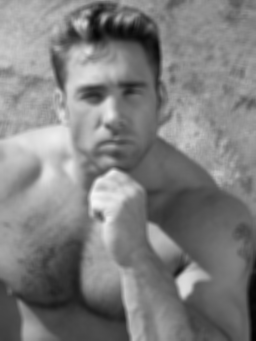

Time GPU:  1.3412141799926758


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/lab HPC/img256-341.bmp', cv2.IMREAD_GRAYSCALE)

sigma_d = 400
sigma_r = 400
window_size = 4

print("Billy original")
cv2_imshow(img)

cpu_start = time.time()
cpu_img = bilateral_CPU(img, sigma_d, sigma_r, window_size)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/lab HPC/img256-341copy.bmp', cpu_img)
print("Billy CPU")
cv2_imshow(cpu_img)
print('Time CPU: ', cpu_time)

gpu_start = time.time()
gpu_img = bilateral_filter(img, sigma_d, sigma_r, window_size)
gpu_time = time.time() - gpu_start
print("Billy GPU")
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/lab HPC/img256-341copy.bmp', gpu_img.astype(np.uint8))
cv2_imshow(gpu_img)
print('Time GPU: ', gpu_time)

original


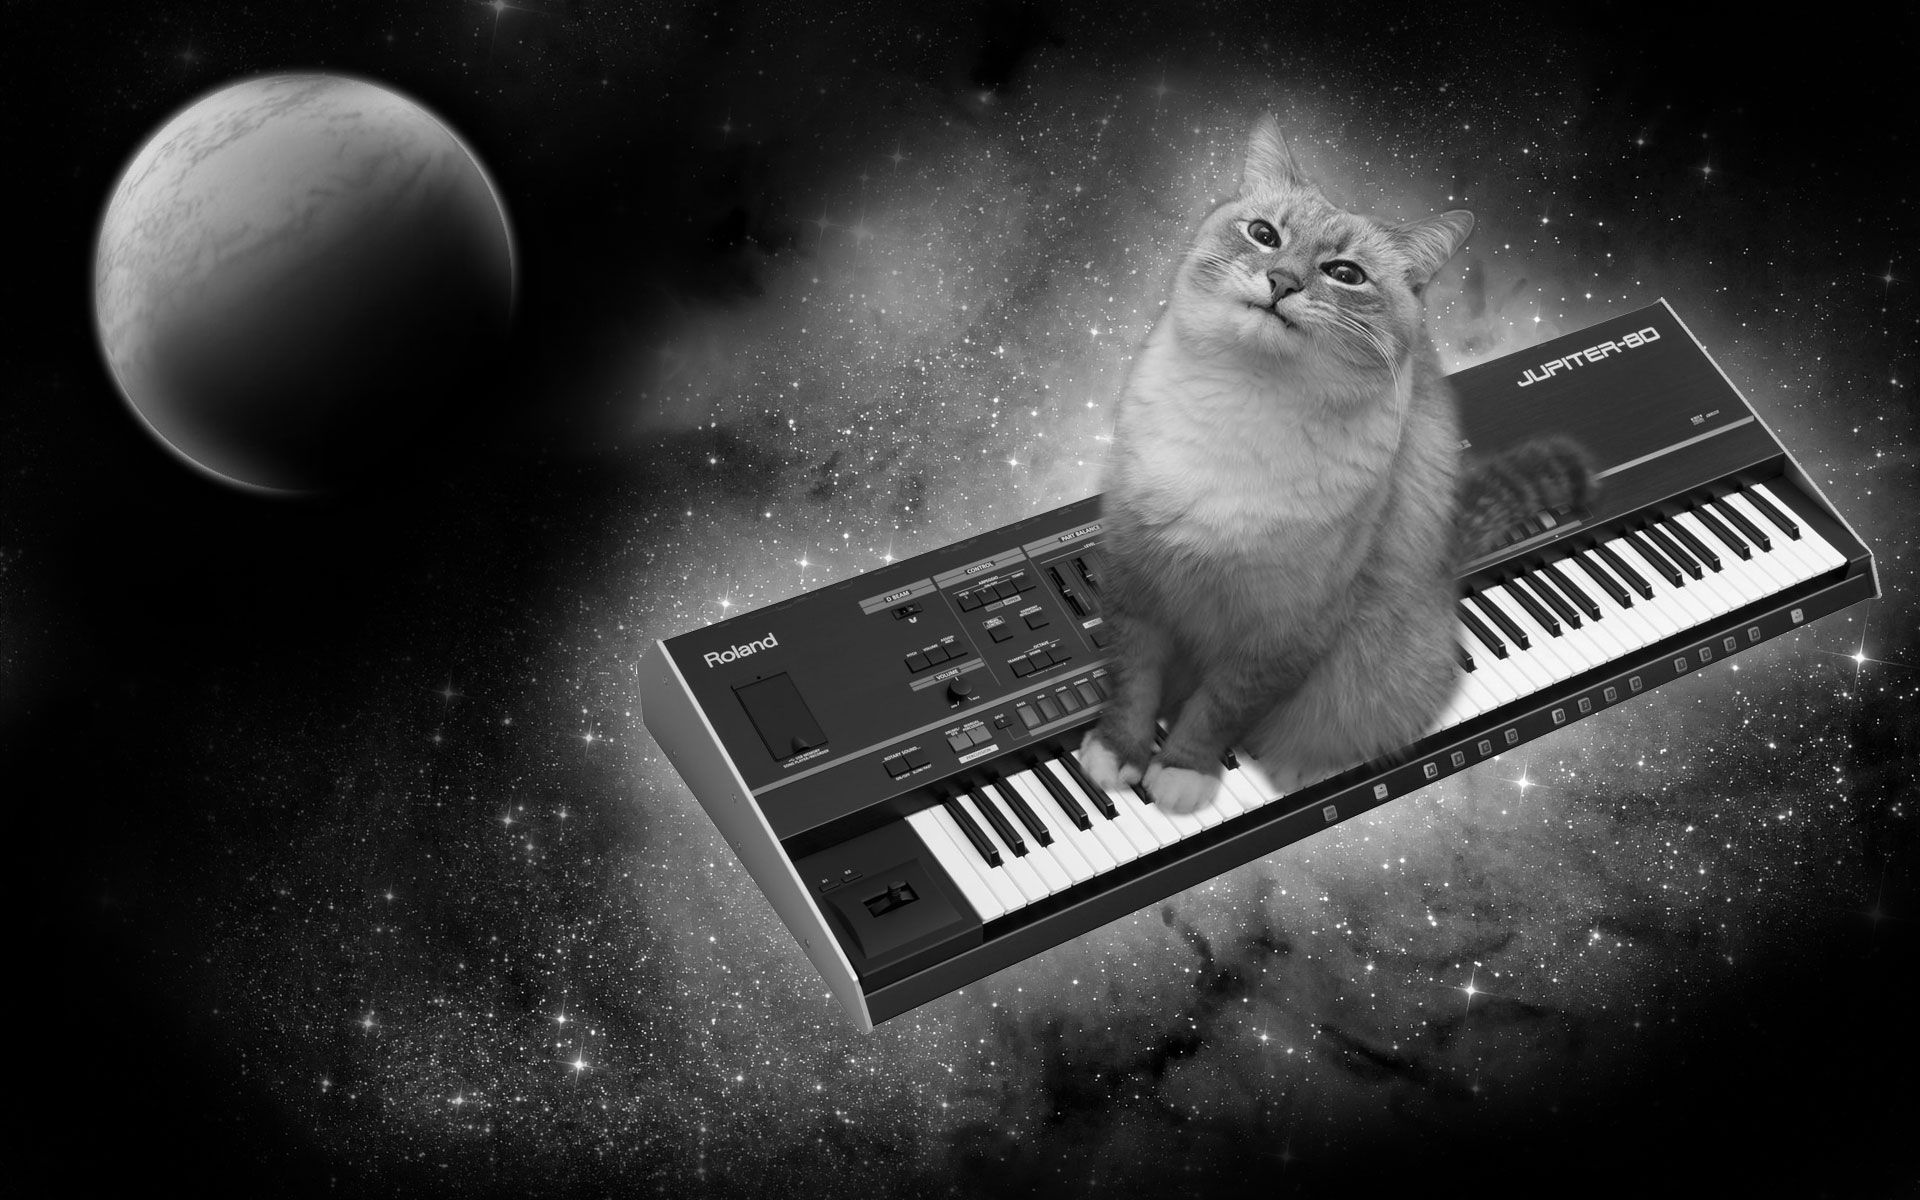

<ipython-input-4-689d7e21db7e>:12: RuntimeWarning: overflow encountered in ubyte_scalars
  r = np.exp(-((image[k, l] - image[i, j]) ** 2) / sigma_r ** 2)


CPU


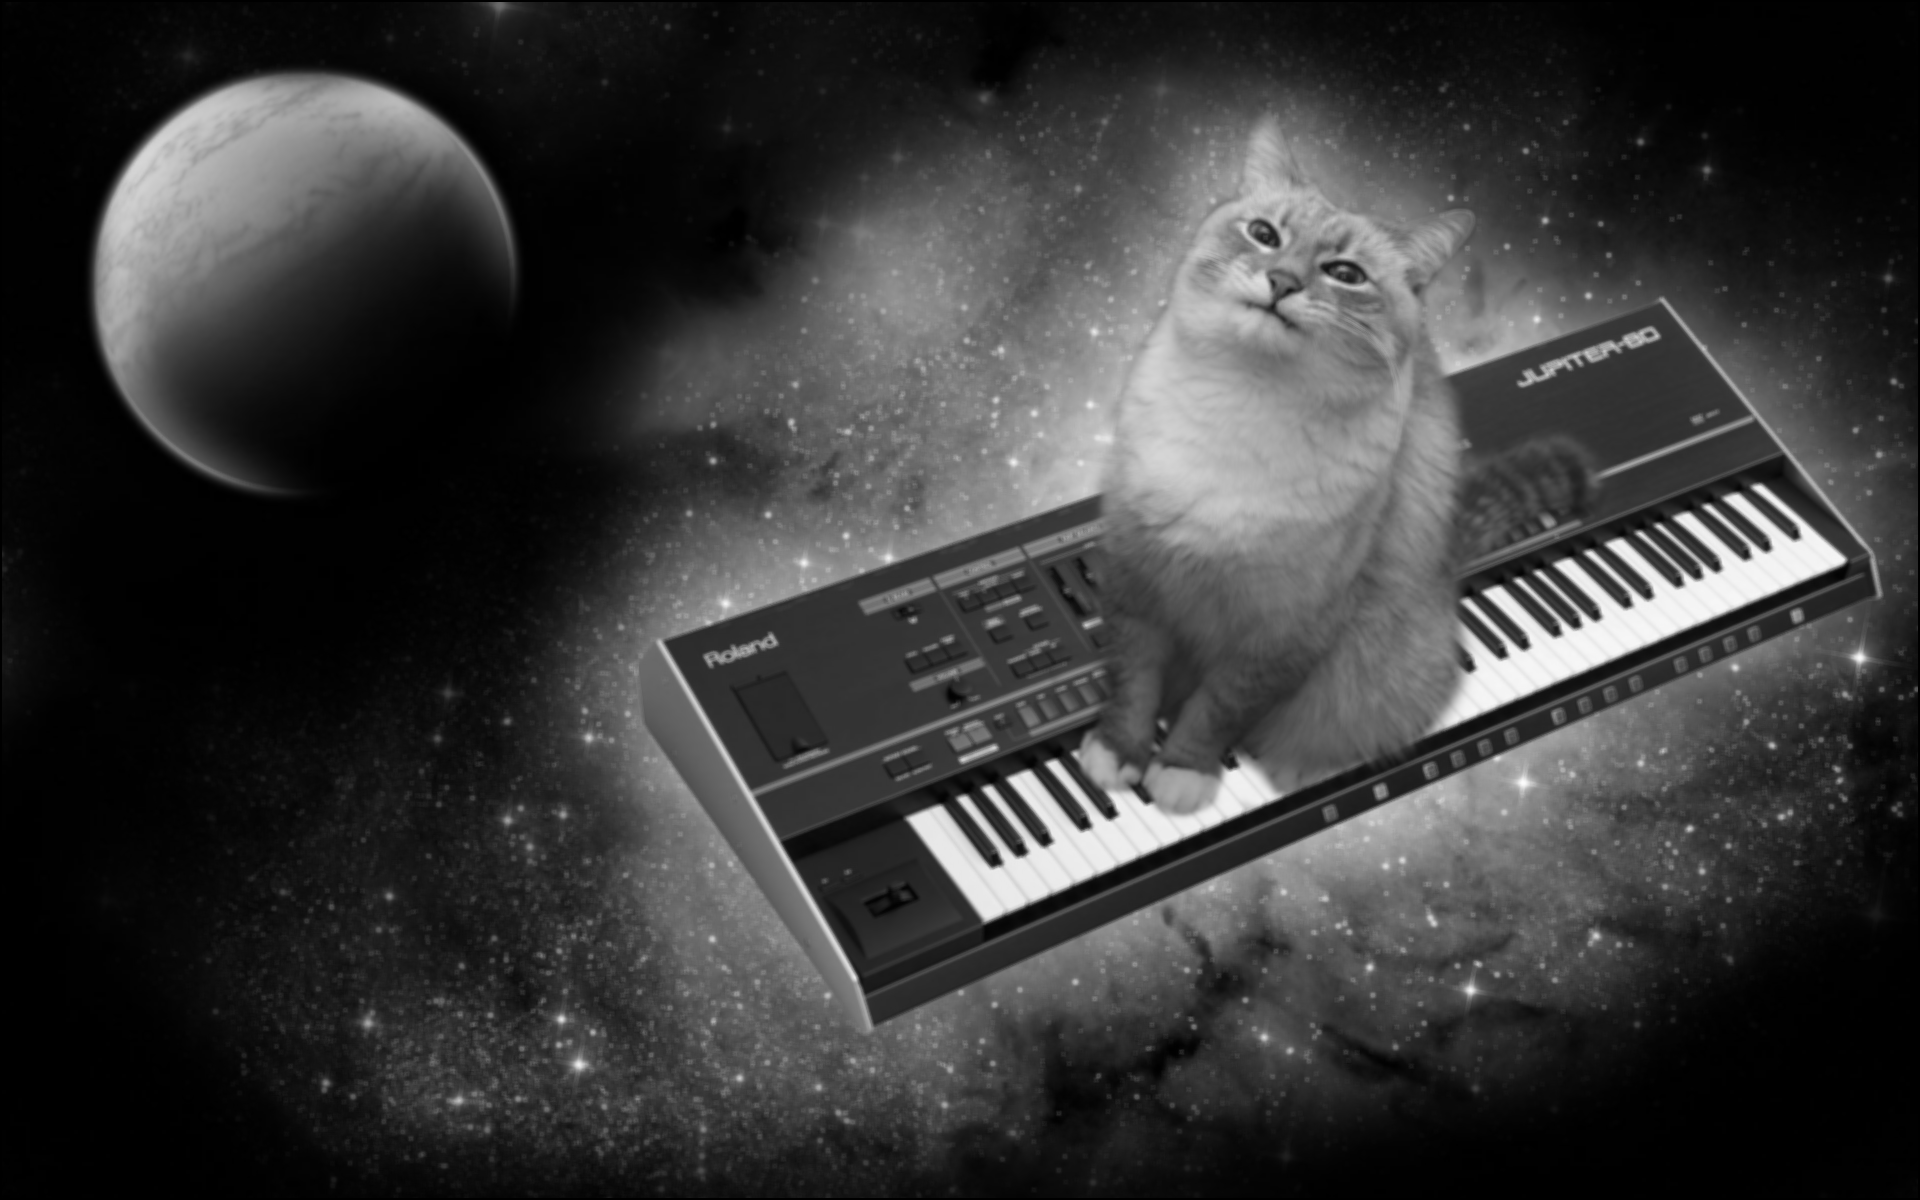

Time CPU:  424.41958594322205
GPU


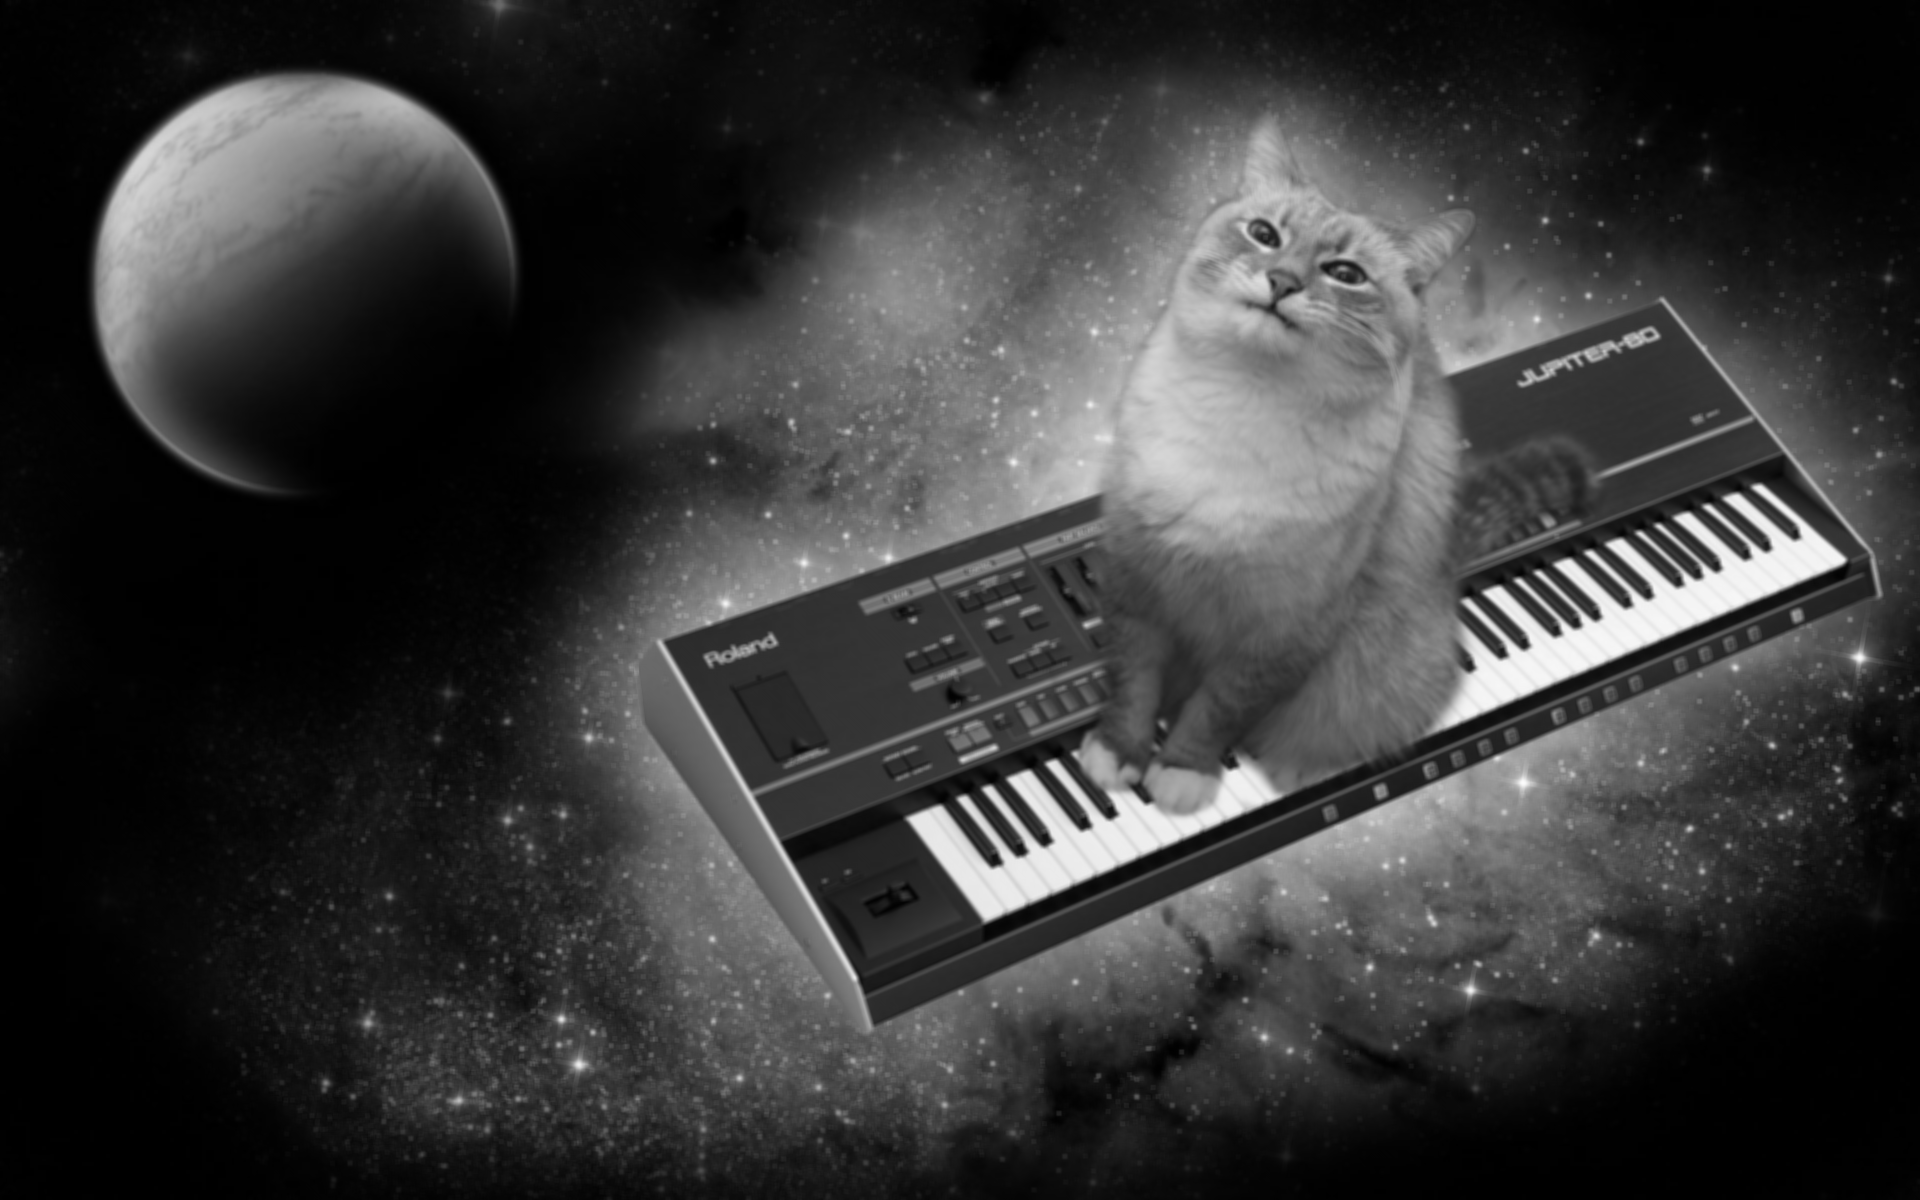

Time GPU:  0.44310832023620605


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/lab HPC/img1920-1200.bmp', cv2.IMREAD_GRAYSCALE)

sigma_d = 400
sigma_r = 400
window_size = 4

print("original")
cv2_imshow(img)

cpu_start = time.time()
cpu_img = bilateral_CPU(img, sigma_d, sigma_r, window_size)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/lab HPC/img1920-1200copy.bmp', cpu_img)
print("CPU")
cv2_imshow(cpu_img)
print('Time CPU: ', cpu_time)

gpu_start = time.time()
gpu_img = bilateral_filter(img, sigma_d, sigma_r, window_size)
gpu_time = time.time() - gpu_start
print("GPU")
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/lab HPC/img1920-1200copy.bmp', gpu_img.astype(np.uint8))
cv2_imshow(gpu_img)
print('Time GPU: ', gpu_time)

original


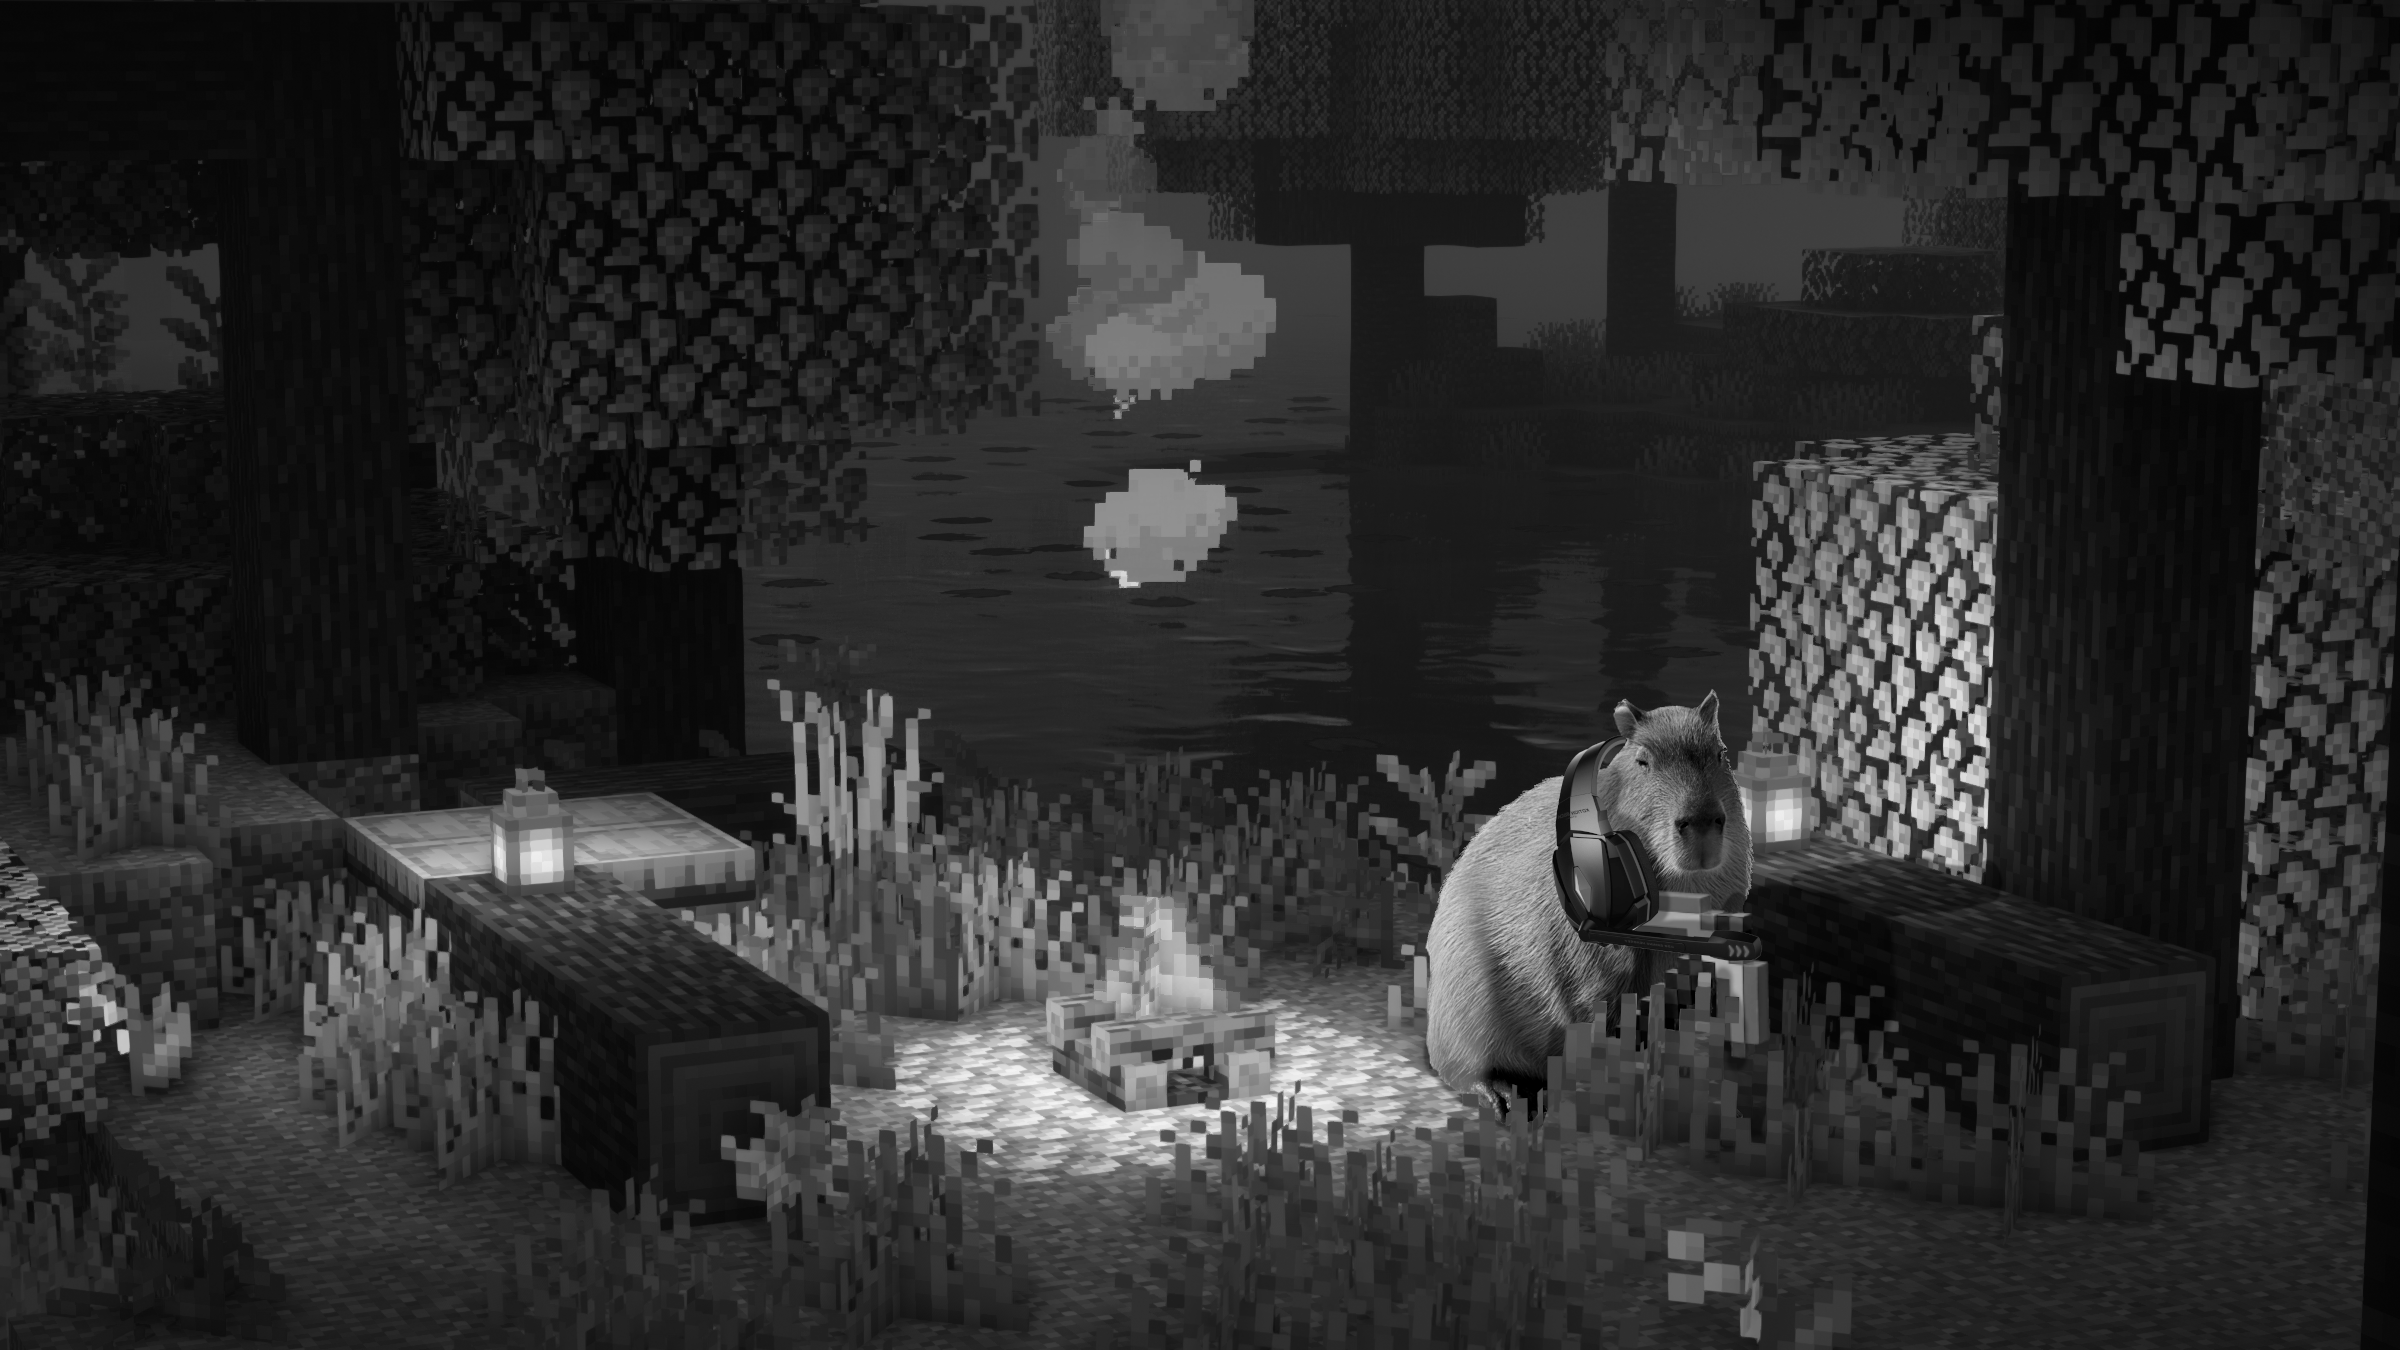

<ipython-input-4-689d7e21db7e>:12: RuntimeWarning: overflow encountered in ubyte_scalars
  r = np.exp(-((image[k, l] - image[i, j]) ** 2) / sigma_r ** 2)


CPU


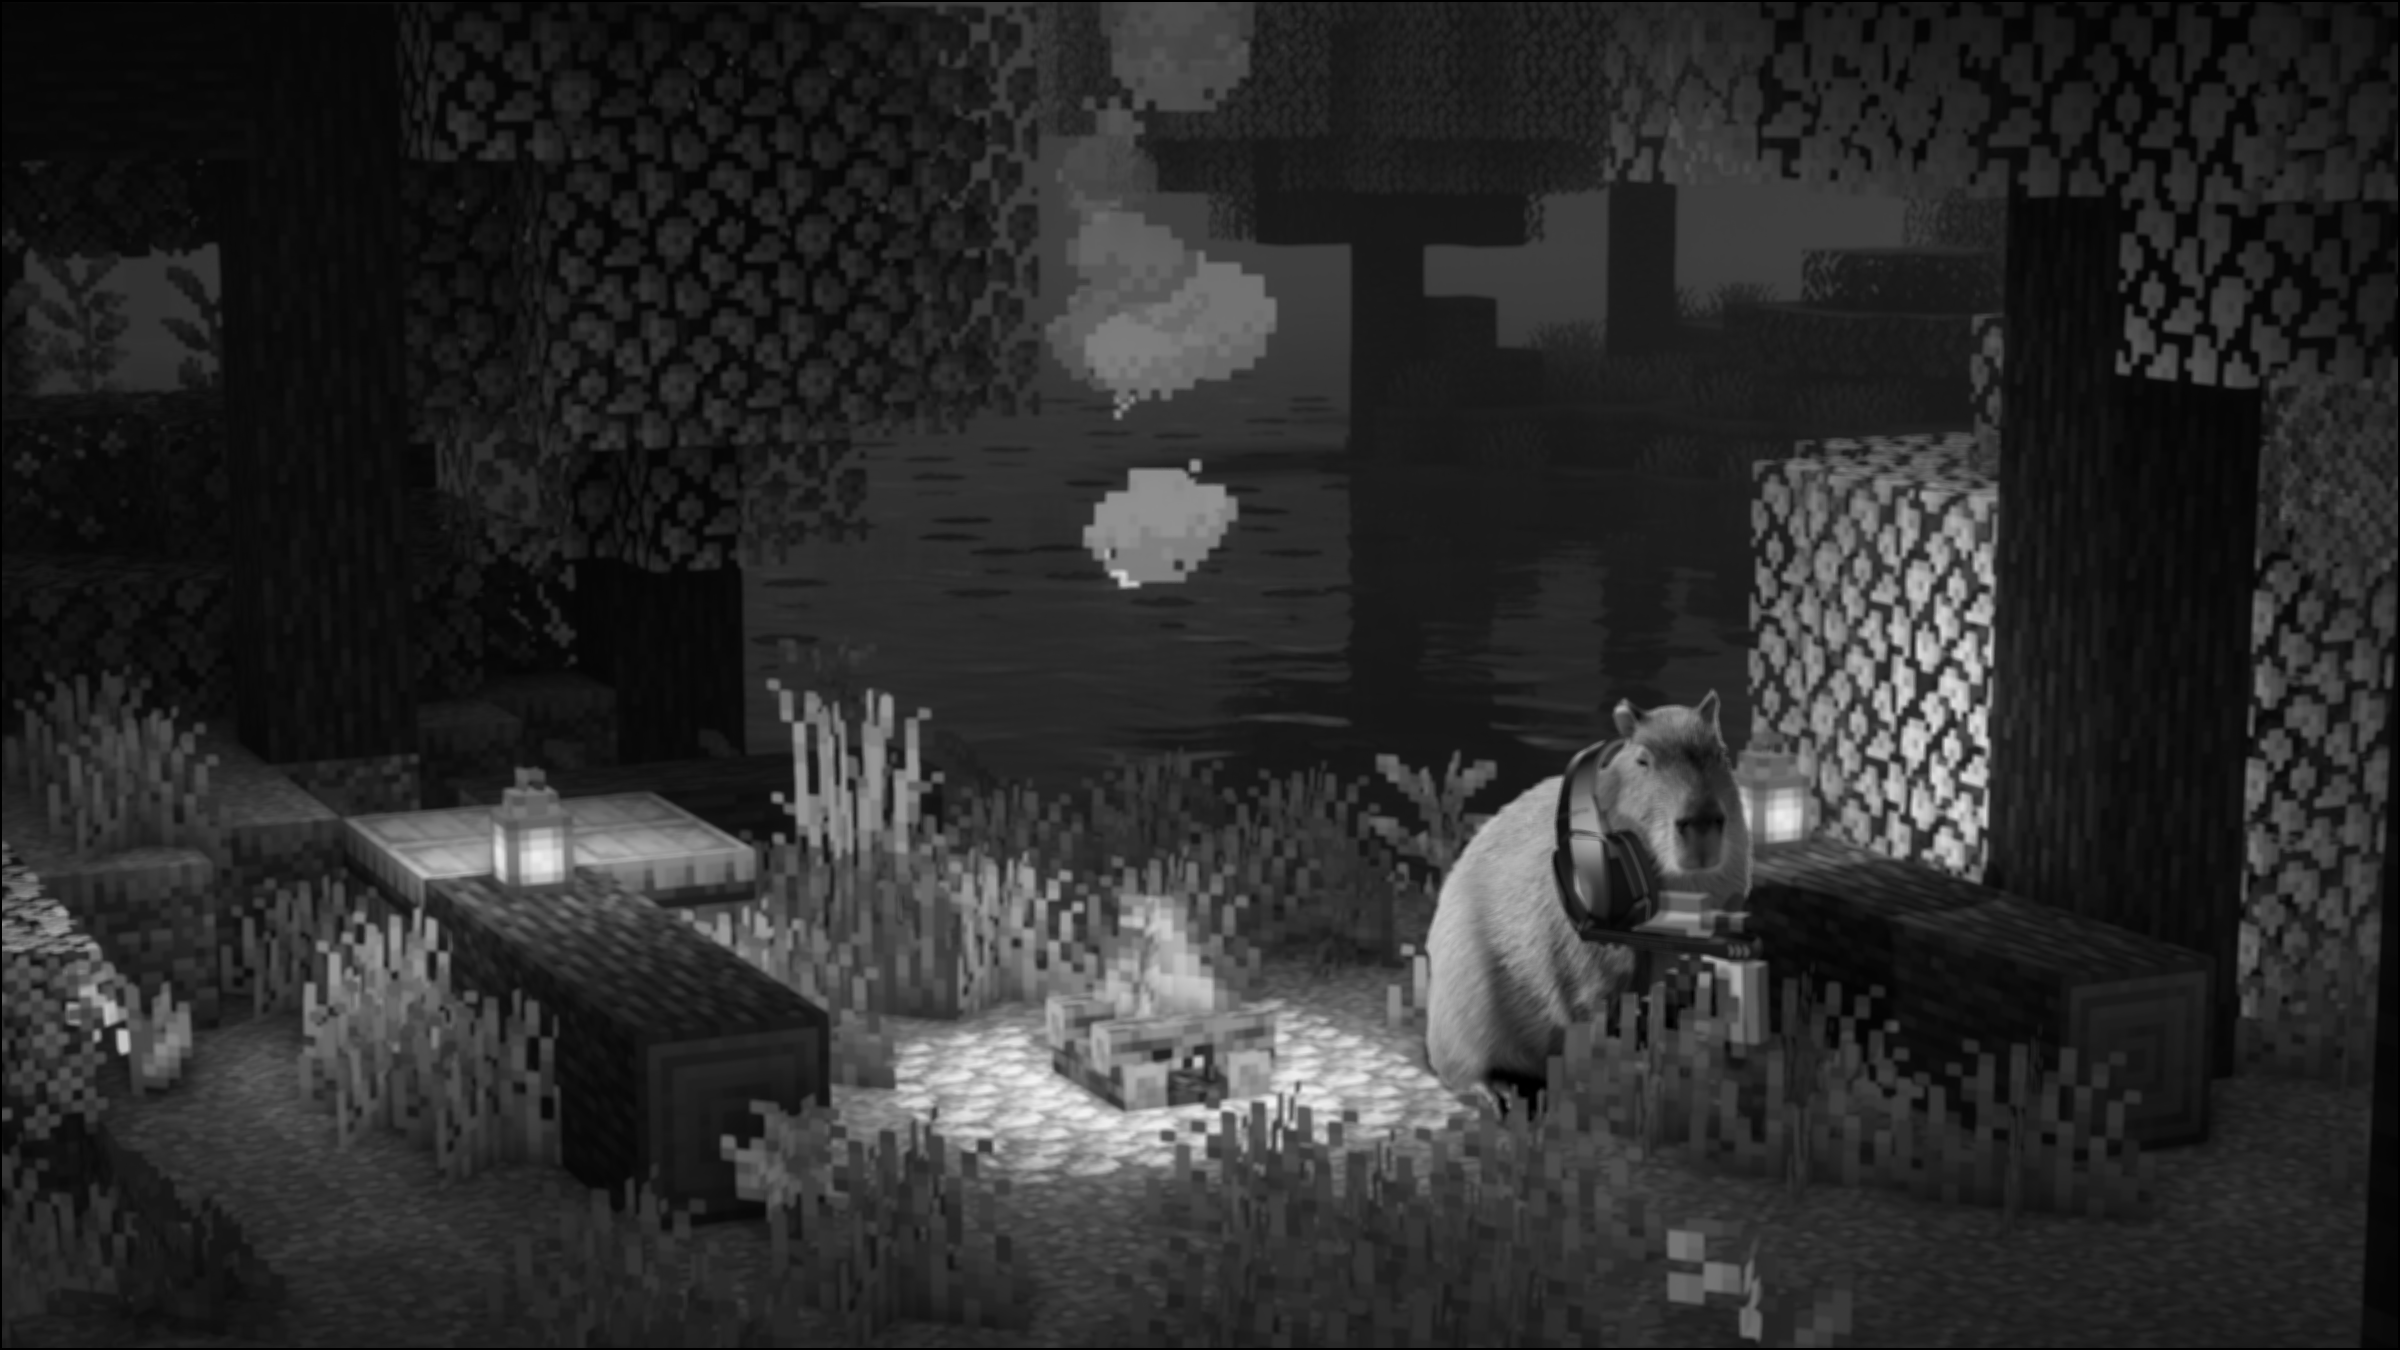

Time CPU:  592.002726316452
GPU


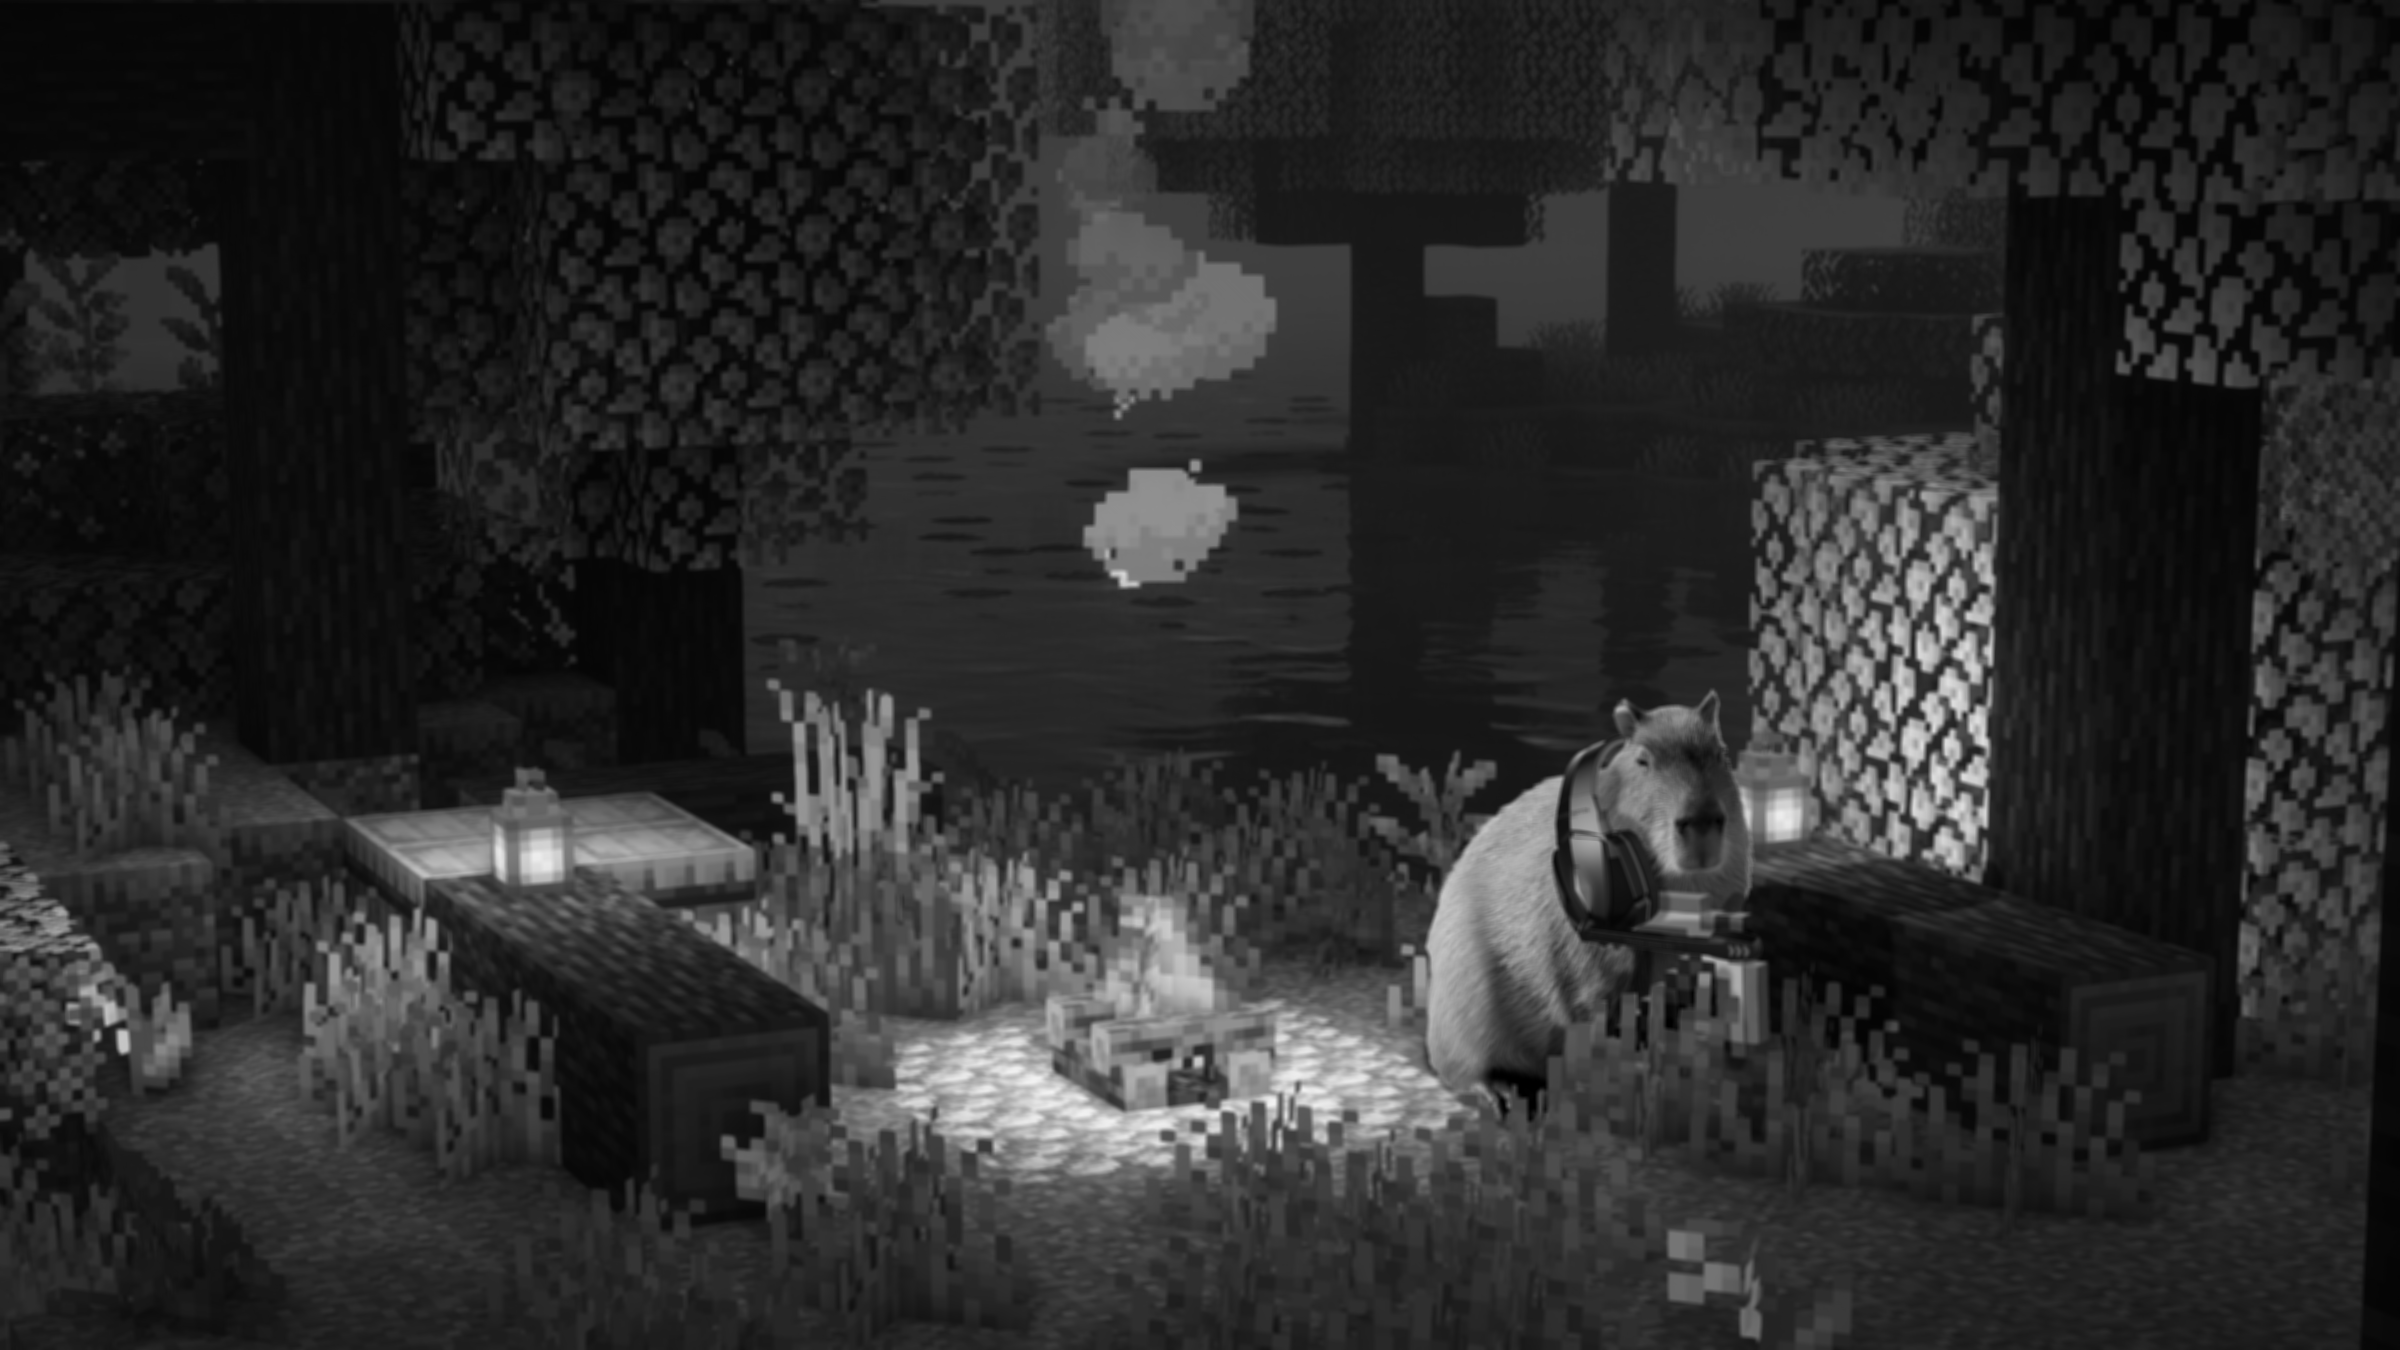

Time GPU:  0.5358686447143555


In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/lab HPC/img2400-1350.bmp', cv2.IMREAD_GRAYSCALE)

sigma_d = 400
sigma_r = 400
window_size = 4

print("original")
cv2_imshow(img)

cpu_start = time.time()
cpu_img = bilateral_CPU(img, sigma_d, sigma_r, window_size)
cpu_time = time.time() - cpu_start
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/lab HPC/img2400-1350copy.bmp', cpu_img)
print("CPU")
cv2_imshow(cpu_img)
print('Time CPU: ', cpu_time)

gpu_start = time.time()
gpu_img = bilateral_filter(img, sigma_d, sigma_r, window_size)
gpu_time = time.time() - gpu_start
print("GPU")
cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/lab HPC/img2400-1350copy.bmp', gpu_img.astype(np.uint8))
cv2_imshow(gpu_img)
print('Time GPU: ', gpu_time)

Как видно, при низком разрешении разница между GPU и CPU уже заметна, но при работе с изображением в более высоком разрешении и большим количеством деталей разница между GPU и CPU коллосальна. При том, получился интересный результат, что изображения с высоким разрешением на GPU обработались быстрее.